# Constructing $A$

Scratch work for streamlining the process of creating the projection matrix $A$

In [17]:
import os, sys, time
import numpy as np
from astropy.table import Table
import numba
import scipy.special

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Evaluating the Legendre polynomials for the PSF parameters

In [2]:
#- Read the PSF parameters from a PSF file without using specter
psfdata = Table.read('psf.fits')

In [3]:
psfdata.colnames

['PARAM', 'WAVEMIN', 'WAVEMAX', 'COEFF']

In [4]:
wavelengths = np.arange(psfdata['WAVEMIN'][0], psfdata['WAVEMAX'][0], 0.8)

In [7]:
def evalcoeffs(wavelengths, psfdata):
    wavemin, wavemax = psfdata['WAVEMIN'][0], psfdata['WAVEMAX'][0]
    wx = (wavelengths - wavemin) * (2.0 / (wavemax - wavemin)) - 1.0
    L = np.polynomial.legendre.legvander(wx, psfdata.meta['LEGDEG'])
    
    p = dict()
    nparam, nspec, ndeg = psfdata['COEFF'].shape
    nwave = L.shape[0]
    p['GH'] = np.zeros((psfdata.meta['GHDEGX']+1, psfdata.meta['GHDEGY']+1, nspec, nwave))
    for name, coeff in zip(psfdata['PARAM'], psfdata['COEFF']):
        name = name.strip()
        if name.startswith('GH-'):
            i, j = map(int, name.split('-')[1:3])
            p['GH'][i,j] = L.dot(coeff.T).T
        else:
            p[name] = L.dot(coeff.T).T
    
    return p

%time p = evalcoeffs(wavelengths, psfdata)

CPU times: user 1.49 s, sys: 372 ms, total: 1.86 s
Wall time: 2.06 s


In [8]:
p.keys()

dict_keys(['GH', 'X', 'Y', 'GHSIGX', 'GHSIGY', 'TAILAMP', 'TAILCORE', 'TAILXSCA', 'TAILYSCA', 'TAILINDE', 'CONT'])

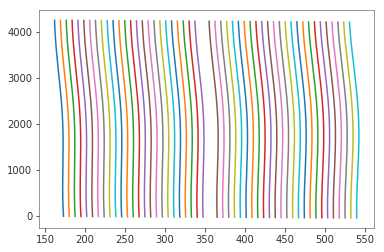

In [9]:
for i in range(50):
    plot(p['X'][i], p['Y'][i])

In [10]:
p['GHSIGX']

array([[ 1.04749257,  1.04766598,  1.04783908, ...,  1.18618871,
         1.18632843,  1.1864683 ],
       [ 1.04707109,  1.0472445 ,  1.04741758, ...,  1.18575304,
         1.18589276,  1.18603263],
       [ 1.04664961,  1.046823  ,  1.04699608, ...,  1.18531736,
         1.18545708,  1.18559695],
       ..., 
       [ 1.0939827 ,  1.0940508 ,  1.09411878, ...,  1.20420452,
         1.20447391,  1.20474374],
       [ 1.09460524,  1.0946731 ,  1.09474086, ...,  1.20418398,
         1.20445313,  1.20472273],
       [ 1.09522775,  1.0952954 ,  1.09536293, ...,  1.20416343,
         1.20443236,  1.20470173]])

In [11]:
psfdata.meta

OrderedDict([('comments',
              ['------------------------------------------------------------------------',
               'PSF generated by specex, https://github.com/julienguy/specex',
               'PSF fit date 2015-01-12',
               '-',
               'Each row of the table contains the data vector of one PSF parameter',
               'The size of the vector is ((FIBERMAX-FIBERMIN+1)*(LEGDEG+1))',
               'Description of  the NPARAMS parameters :',
               'X        : CCD column coordinate (as a function of fiber and wavelength)',
               'Y        : CCD row coordinate (as a function of fiber and wavelength)',
               '         (X,Y)=(0,0) means that PSF is centered on center of first pixel',
               'GHSIGX   : Sigma of first Gaussian along CCD columns for PSF core',
               'GHSIGY   : Sigma of first Gaussian along CCD rows for PSF core',
               'GH-i-j   : Hermite pol. coefficents, i along columns, j along rows,

## Gauss-Hermite

In [12]:
from numpy.polynomial import hermite_e as He

In [13]:
ispec = 0
    
#- spot size (ny,nx)
nx = psfdata.meta['HSIZEX']
ny = psfdata.meta['HSIZEY']
nwave = len(wavelengths)
print('Spot size (ny,nx) = {},{}'.format(ny, nx))
print('nwave = {}'.format(nwave))

xedges = np.repeat(np.arange(nx+1) - nx//2, nwave).reshape(nx+1, nwave)
yedges = np.repeat(np.arange(ny+1) - ny//2, nwave).reshape(ny+1, nwave)
print('xedges.shape = {}'.format(xedges.shape))
print('yedges.shape = {}'.format(yedges.shape))

#- TODO: + or -
xedges = ((xedges + p['X'][ispec]%1)/p['GHSIGX'][ispec])
yedges = ((yedges + p['Y'][ispec]%1)/p['GHSIGY'][ispec])    

ghdegx = psfdata.meta['GHDEGX']
ghdegy = psfdata.meta['GHDEGY']

HVx = He.hermevander(xedges, ghdegx).T
HVy = He.hermevander(yedges, ghdegy).T
print('HVx.shape = {}'.format(HVx.shape))
print('HVy.shape = {}'.format(HVy.shape))

Spot size (ny,nx) = 8,14
nwave = 2802
xedges.shape = (15, 2802)
yedges.shape = (9, 2802)
HVx.shape = (9, 2802, 15)
HVy.shape = (9, 2802, 9)


In [14]:
#- WIP
Gx = np.exp(-0.5*xedges**2).T / np.sqrt(2. * np.pi)   # (nwave, nedges)
Gy = np.exp(-0.5*yedges**2).T / np.sqrt(2. * np.pi)
print('Gx.shape = {}'.format(Gx.shape))
print('Gy.shape = {}'.format(Gy.shape))

Gx.shape = (2802, 15)
Gy.shape = (2802, 9)


In [15]:
# -np.diff(HVx[1,0] * np.exp(-0.5*xx**2) / np.sqrt(2. * np.pi))

GHx = HVx * Gx
GHy = HVy * Gy
print('GHx.shape = {}'.format(GHx.shape))
print('GHy.shape = {}'.format(GHy.shape))

GHx.shape = (9, 2802, 15)
GHy.shape = (9, 2802, 9)


In [18]:
pGHx = np.zeros((ghdegx+1, nwave, nx))
pGHy = np.zeros((ghdegy+1, nwave, ny))
pGHx[0] = 0.5 * np.diff(scipy.special.erf(xedges/np.sqrt(2.)).T)
pGHy[0] = 0.5 * np.diff(scipy.special.erf(yedges/np.sqrt(2.)).T)
pGHx[1:] = GHx[:ghdegx,:,0:nx] - GHx[:ghdegx,:,1:nx+1]
pGHy[1:] = GHy[:ghdegy,:,0:ny] - GHy[:ghdegy,:,1:ny+1]

In [19]:
print("p['GH'].shape = {}".format(p['GH'].shape))

p['GH'].shape = (9, 9, 500, 2802)


In [20]:
@numba.jit
def evalspot(iwave, ghc):
    #- globals: pGHx, pGHy,
    nx = pGHx.shape[-1]
    ny = pGHy.shape[-1]
    spot = np.zeros((ny,nx))
    tmpspot = np.zeros((ny,nx))
    for i in range(pGHx.shape[0]):
        px = pGHx[i,iwave]
        for j in range(0, pGHy.shape[0]):
            py = pGHy[j,iwave]
            np.outer(py, px, out=tmpspot)
            spot += ghc[i,j] * tmpspot
    
    return spot

iwave = 500
ispec = 20
%time spot = evalspot(iwave=0, ghc=p['GH'][:,:,ispec,iwave])

CPU times: user 1.22 s, sys: 39 ms, total: 1.26 s
Wall time: 1.49 s


In [21]:
pGHx.shape, pGHy.shape, ny, nx

((9, 2802, 14), (9, 2802, 8), 8, 14)

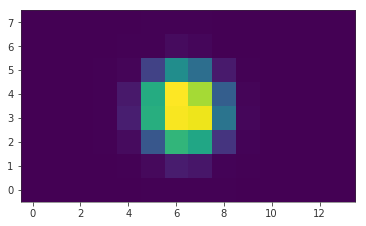

In [22]:
imshow(spot)

In [23]:
ghc=p['GH'][:,:,ispec,iwave].copy()
%timeit spot = evalspot(iwave=0, ghc=ghc)

63.5 µs ± 5.58 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Evaluate multiple spots at once

In [37]:
t0 = time.time()
ispec = 0
spots = np.zeros((nwave, ny, nx))
for iwave in range(nwave):
    spots[iwave] = evalspot(iwave=iwave, ghc=p['GH'][:,:,ispec,iwave])
dt = time.time() - t0
print(dt)

0.2379918098449707


In [50]:
@numba.jit(nopython=True)
def multispot(ghc):
    #- globals: pGHx, pGHy
    nx = pGHx.shape[-1]
    ny = pGHy.shape[-1]
    nwave = pGHx.shape[1]
    spots = np.zeros((nwave, ny, nx))

    tmpspot = np.zeros((ny,nx))
    for iwave in range(nwave):
        for i in range(pGHx.shape[0]):
            px = pGHx[i,iwave]
            for j in range(0, pGHy.shape[0]):
                py = pGHy[j,iwave]
                c = ghc[i,j,iwave]
                for iy in range(len(py)):
                    for ix in range(len(px)):
                        spots[iwave, iy, ix] += c * py[iy] * px[ix]
    
    return spots

spots = multispot(p['GH'][:,:,ispec,:])

In [51]:
%timeit spots = multispot(p['GH'][:,:,ispec,:])

19.6 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
21e-3*500

10.5

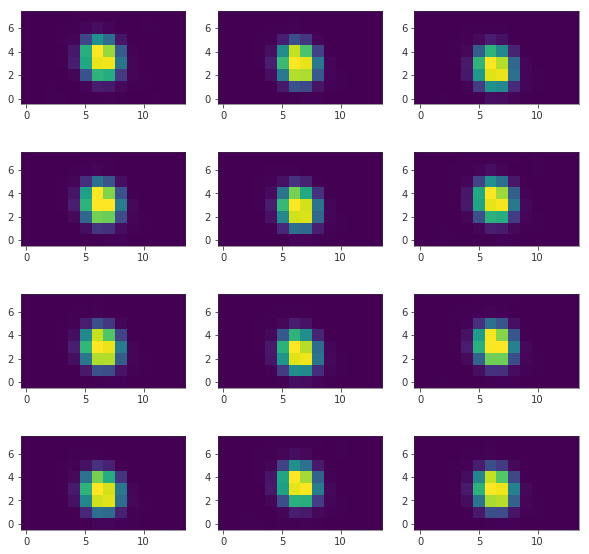

In [52]:
figure(figsize=(10,10))
for i in range(12):
    subplot(4,3,i+1)
    imshow(spots[i])

### Scratch work

In [ ]:
x = p['X'][0]
y = p['Y'][0]
plot(x, y)

In [ ]:
nx = psfdata.meta['HSIZEX']
ny = psfdata.meta['HSIZEY']
nwave = len(wavelengths)
ispec = 0

xedges = np.repeat(np.arange(nx+1) - nx//2, nwave).reshape(nx+1, nwave)
yedges = np.repeat(np.arange(ny+1) - ny//2, nwave).reshape(ny+1, nwave)

#- TODO: + or -
xedges = ((xedges + p['X'][ispec]%1)/p['GHSIGX'][ispec])
yedges = ((yedges + p['Y'][ispec]%1)/p['GHSIGY'][ispec])

In [ ]:
xedges.shape, yedges.shape

In [ ]:
HVx = He.hermevander(xedges, psfdata.meta['GHDEGX']).T
HVy = He.hermevander(yedges, psfdata.meta['GHDEGY']).T
HVx.shape, HVy.shape

In [ ]:
import scipy.special
def pgh(xedges, m):
    '''
    Uses the relationship
    Integral{ H_k(x) exp(-0.5 x^2) dx} = -H_{k-1}(x) exp(-0.5 x^2) + const
    '''
    if m > 0:
        fn = scipy.special.hermitenorm(m-1)
        y  = -fn(xedges) * np.exp(-0.5 * xedges**2) / np.sqrt(2. * np.pi)
        return (y[1:] - y[0:-1])
    else:            
        y = scipy.special.erf(xedges/np.sqrt(2.))
        return 0.5 * (y[1:] - y[0:-1])

pgh(xedges[:,0], m=2)

In [ ]:
xx = xedges[:,0]
-np.diff(HVx[1,0] * np.exp(-0.5*xx**2) / np.sqrt(2. * np.pi))

In [ ]:
gx = np.exp(-0.5*xedges**2).T / np.sqrt(2. * np.pi)   # (nwave, nedges)
gy = np.exp(-0.5*yedges**2).T / np.sqrt(2. * np.pi)
print(gx.shape, gy.shape)

GHx = HVx.copy()
for i in range(GHx.shape[0]):
    GHx[i] *= gx

GHy = HVy.copy()
for j in range(GHy.shape[0]):
    GHy[j] *= gy

### TODO ###
### pre-cache np.diff(GHx) etc.
    
def evalspot(HVx, HVy, ispec, iwave, ghc):
    '''
    HVx[i,iwave,ix]
    HVy[j,iwave,iy]
    ghc[i,j,ispec,iwave]
    '''
    xe = xedges[:, iwave]  #- GLOBAL
    ye = yedges[:, iwave]  #- GLOBAL
    px0 = 0.5 * np.diff(scipy.special.erf(xe/np.sqrt(2.)))
    py0 = 0.5 * np.diff(scipy.special.erf(ye/np.sqrt(2.)))

    nx = HVx.shape[-1]
    ny = HVy.shape[-1]
    spot = np.zeros((ny-1,nx-1))
    for i in range(HVx.shape[0]):
        # px = pgh(xedges[:,iwave], i)
        if i > 0:
            # px = np.diff(HVx[i-1,iwave] * gx[iwave])
            px = np.diff(GHx[i-1,iwave])
        else:
            px = px0

        for j in range(HVy.shape[0]):
            # py = pgh(yedges[:,iwave], j)
            if j > 0:
                # py = np.diff(HVy[j-1,iwave] * gy[iwave])
                py = np.diff(GHy[j-1,iwave])
            else:
                py = py0
                
            spot += ghc[i,j,ispec,iwave] * np.outer(py, px)
    
    return spot

spot = evalspot(HVx, HVy, 0, 0, p['GH'])

In [ ]:
HVx.shape, gx.shape

In [ ]:
imshow(spot)

In [ ]:
%timeit spot = evalspot(HVx, HVy, 0, 100, p['GH'])

In [ ]:
855e-6 * 500 * 2800 / 60

In [ ]:
xedges.shape, HVx.shape

In [ ]:
t0 = time.time()
spots = np.zeros((25, nwave, ny, nx))
for ispec in range(25):
    for iwave in range(10):
        spots[ispec, iwave] = evalspot(HVx, HVy, ispec, iwave, p['GH'])

dt = time.time() - t0
print(dt)

In [ ]:
p['GH'].shape

In [ ]:
x = np.linspace(-7, 7, 14)
y = np.linspace(-4, 4, 8)
Vx = He.hermevander(x, deg=7)
Vy = He.hermevander(y, deg=7)
Vx.shape, Vy.shape

In [ ]:
for i in range(Vx.shape[1]):
    plot(x, Vx[:,i] * np.exp(-0.5*x**2))

In [ ]:
T = np.outer(Vx, Vy)
T.shape

In [ ]:
Tx = T.reshape(14,8,12,8)

In [ ]:
imshow(Tx[:,7,:,6])

In [ ]:
x = np.repeat(np.linspace(-1,1), 5).reshape(5, 50)
V = He.hermevander(x, deg=5)
x.shape, V.shape

In [ ]:
x.shape, V.shape